In [117]:
import numpy as np
import mne 
import scipy 
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [100]:
raw_data=mne.io.read_raw_brainvision('mp/NeoRec_2022-12-07_14-10-26.vhdr', preload=True)

Extracting parameters from mp/NeoRec_2022-12-07_14-10-26.vhdr...
Setting channel info structure...
Reading 0 ... 1351953  =      0.000 ...   675.976 secs...


In [6]:
raw_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, x, y, z
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 2000.0 Hz
>

In [17]:
raw_data_acc=raw_data.copy().drop_channels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

<IPython.core.display.Javascript object>


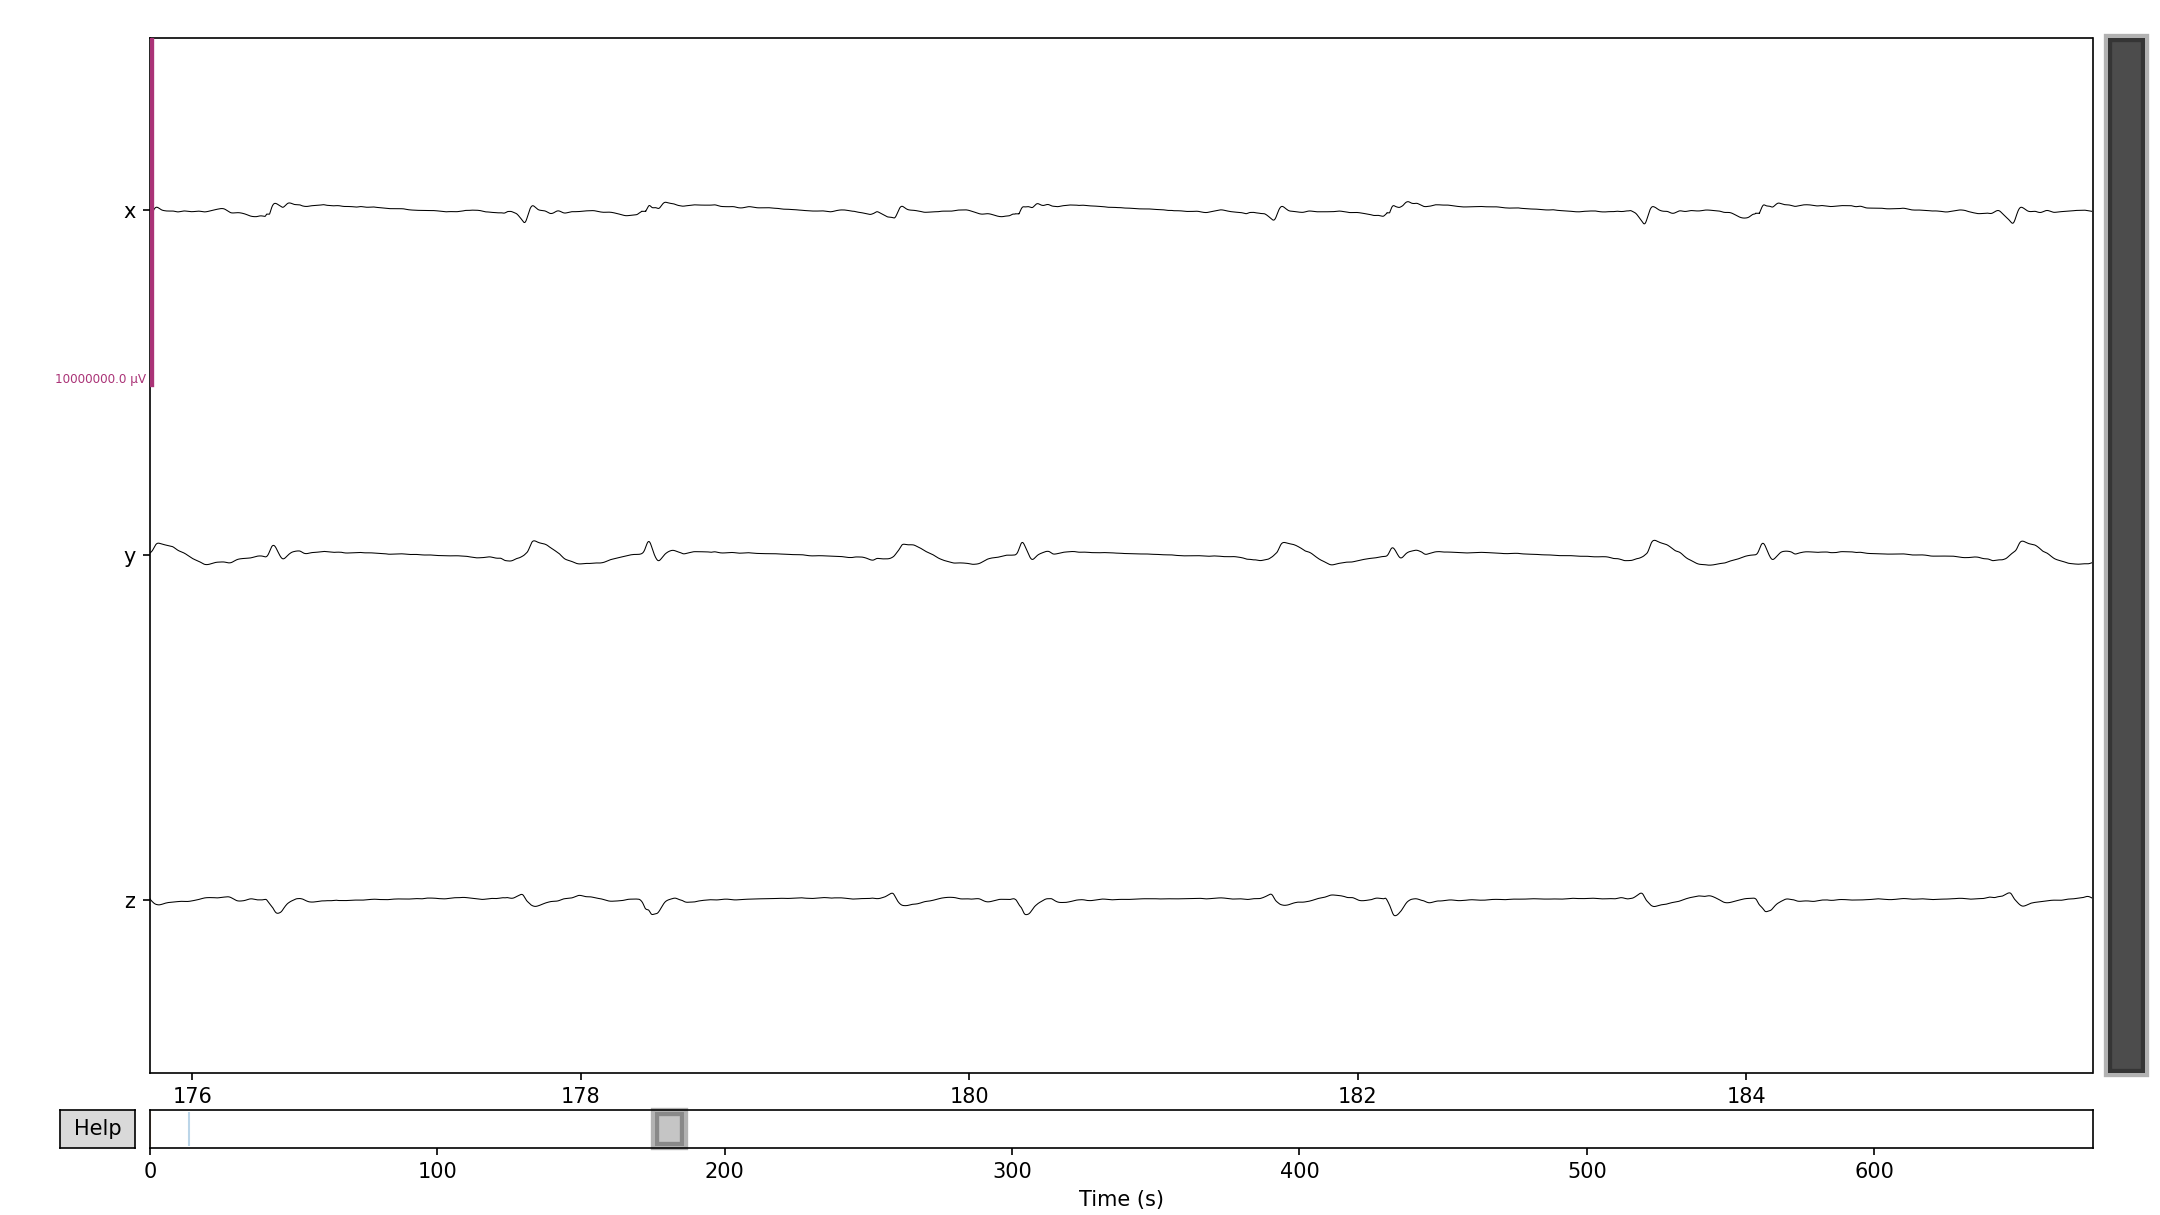

<function matplotlib.pyplot.show(block=None)>

In [21]:
raw_data_acc.plot(scalings={'eeg':0.5e1})
plt.show

In [39]:
xyz_data=raw_data_acc.get_data()


In [ ]:
фаза - 3500

In [40]:
y_data=xyz_data[1,:]

In [48]:
out=np.convolve(y_data,xyz[1,3500:7000], 'same')

<IPython.core.display.Javascript object>


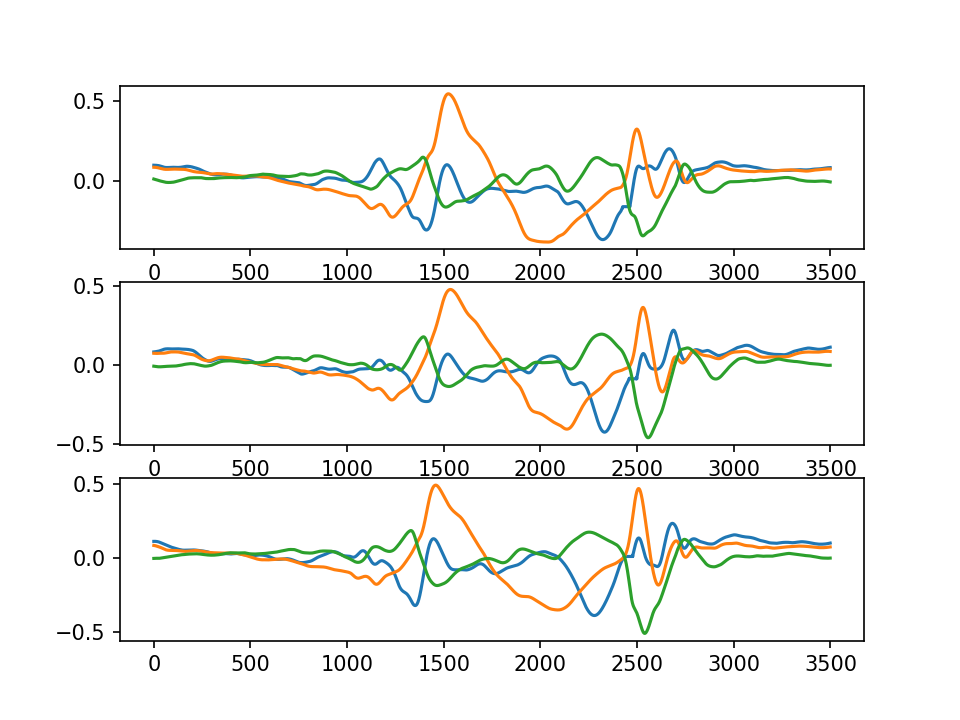

In [38]:
plt.close()

fig,ax=plt.subplots(3,1)
ax[0].plot(xyz[:,0:3500].T)
ax[1].plot(xyz[:,3500:7000].T)
ax[2].plot(xyz[:,7000:10500].T)

In [45]:
out.shape

(1355453,)

<IPython.core.display.Javascript object>


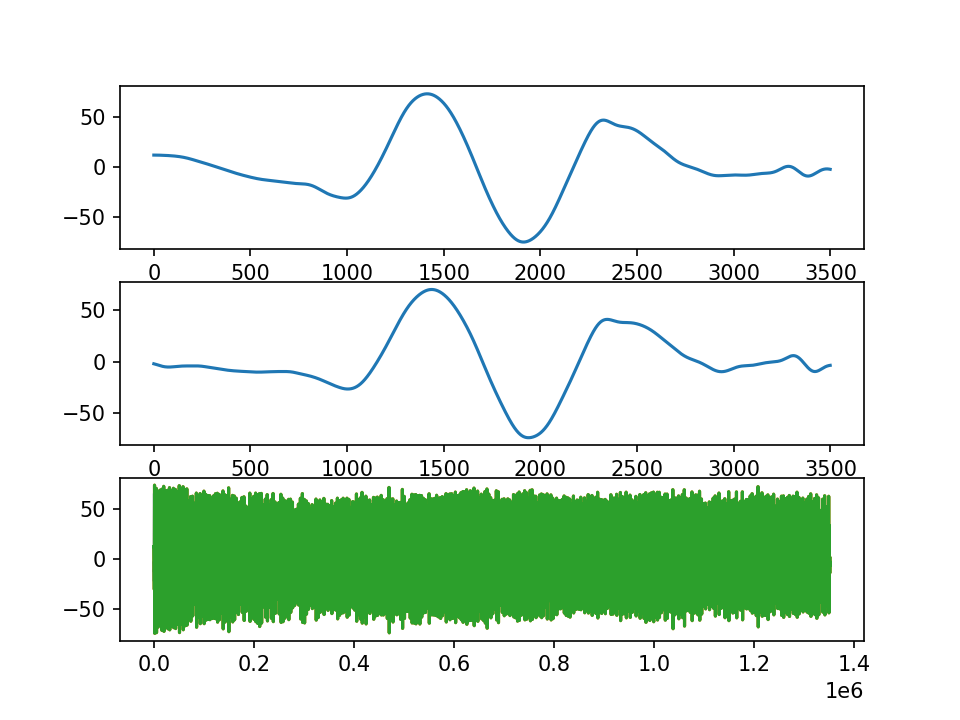

In [49]:
plt.close()

fig,ax=plt.subplots(3,1)
ax[0].plot(out[0:3500])
ax[1].plot(out[3500:7000])
ax[2].plot(out[7000:10500])

<IPython.core.display.Javascript object>


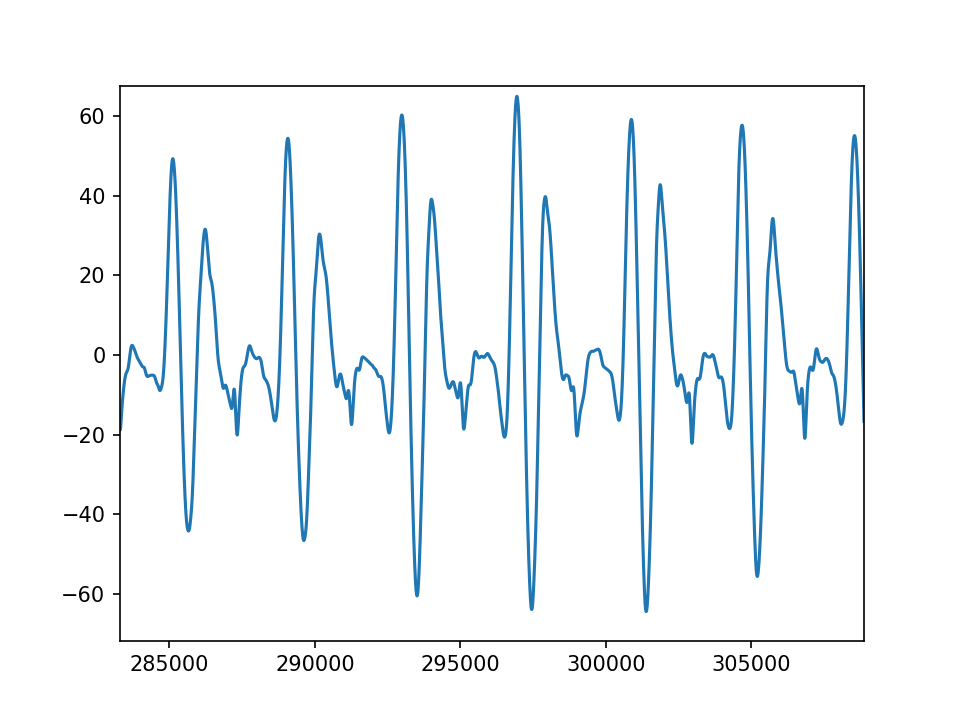

In [52]:
plt.close()
plt.plot(out)

In [71]:
def find_peaks(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_>max_)[0]
    
    if max_flg:
        return inds, max_
    
    else:
        return inds
    
    
def find_peaks_min(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_<min_)[0]
    
    if max_flg:
        return inds, min_
    
    else:
        return inds
    
def reduce_peaks(marks_array_inds,  threhold, with_log=False,):
    
    new_marks_array_inds=[marks_array_inds[0]]
    for i in range(1,len(marks_array_inds)):
        if marks_array_inds[i]-new_marks_array_inds[-1]<threhold:
            if with_log:
                print(i)
        else:
            new_marks_array_inds.append(marks_array_inds[i])

    return new_marks_array_inds


In [72]:
inds=find_peaks(out,1.7)

<IPython.core.display.Javascript object>


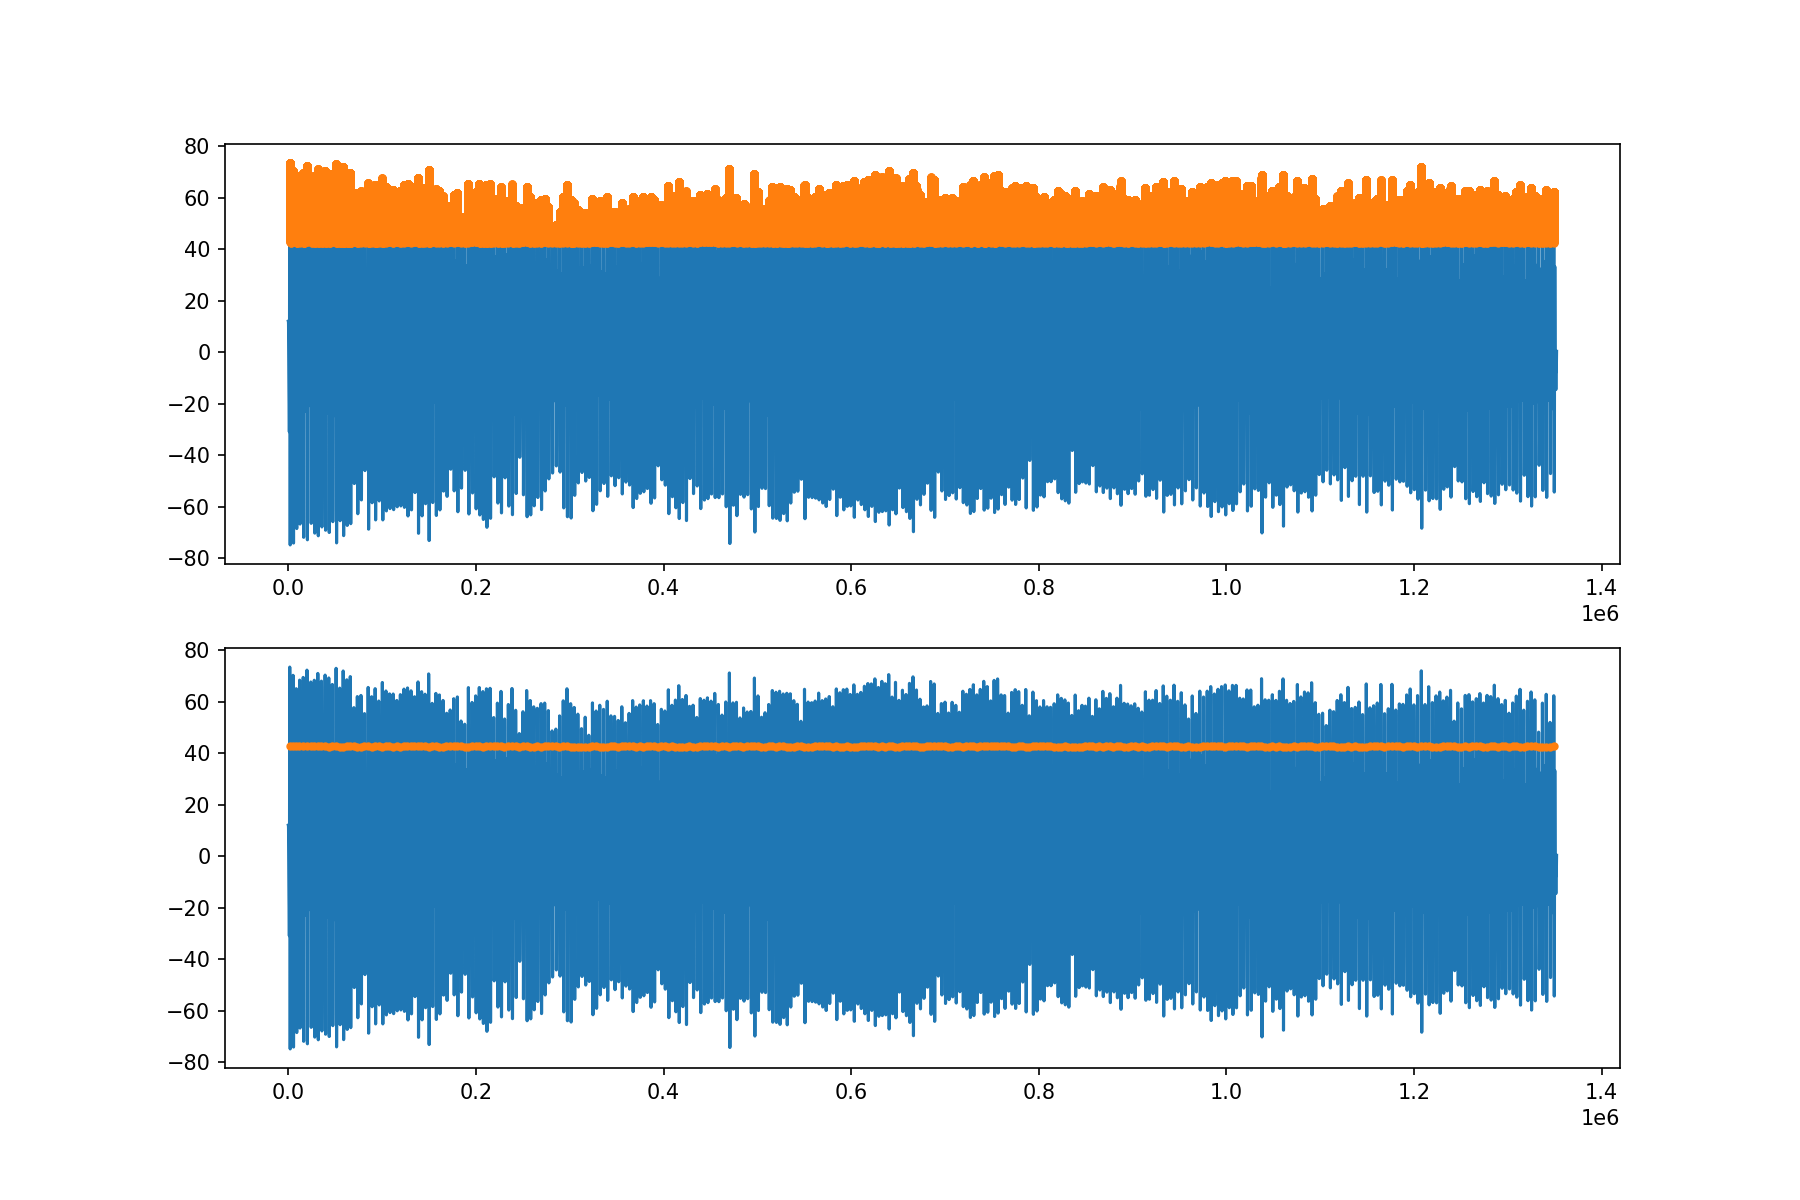

In [73]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(out)
ax[0].plot(inds,out[inds], '.')

new_peaks=reduce_peaks(inds, 2000)
ax[1].plot(out)
ax[1].plot(new_peaks,out[new_peaks], '.')

In [74]:
events_max=new_peaks

In [75]:
inds=find_peaks_min(out,1.7)

<IPython.core.display.Javascript object>


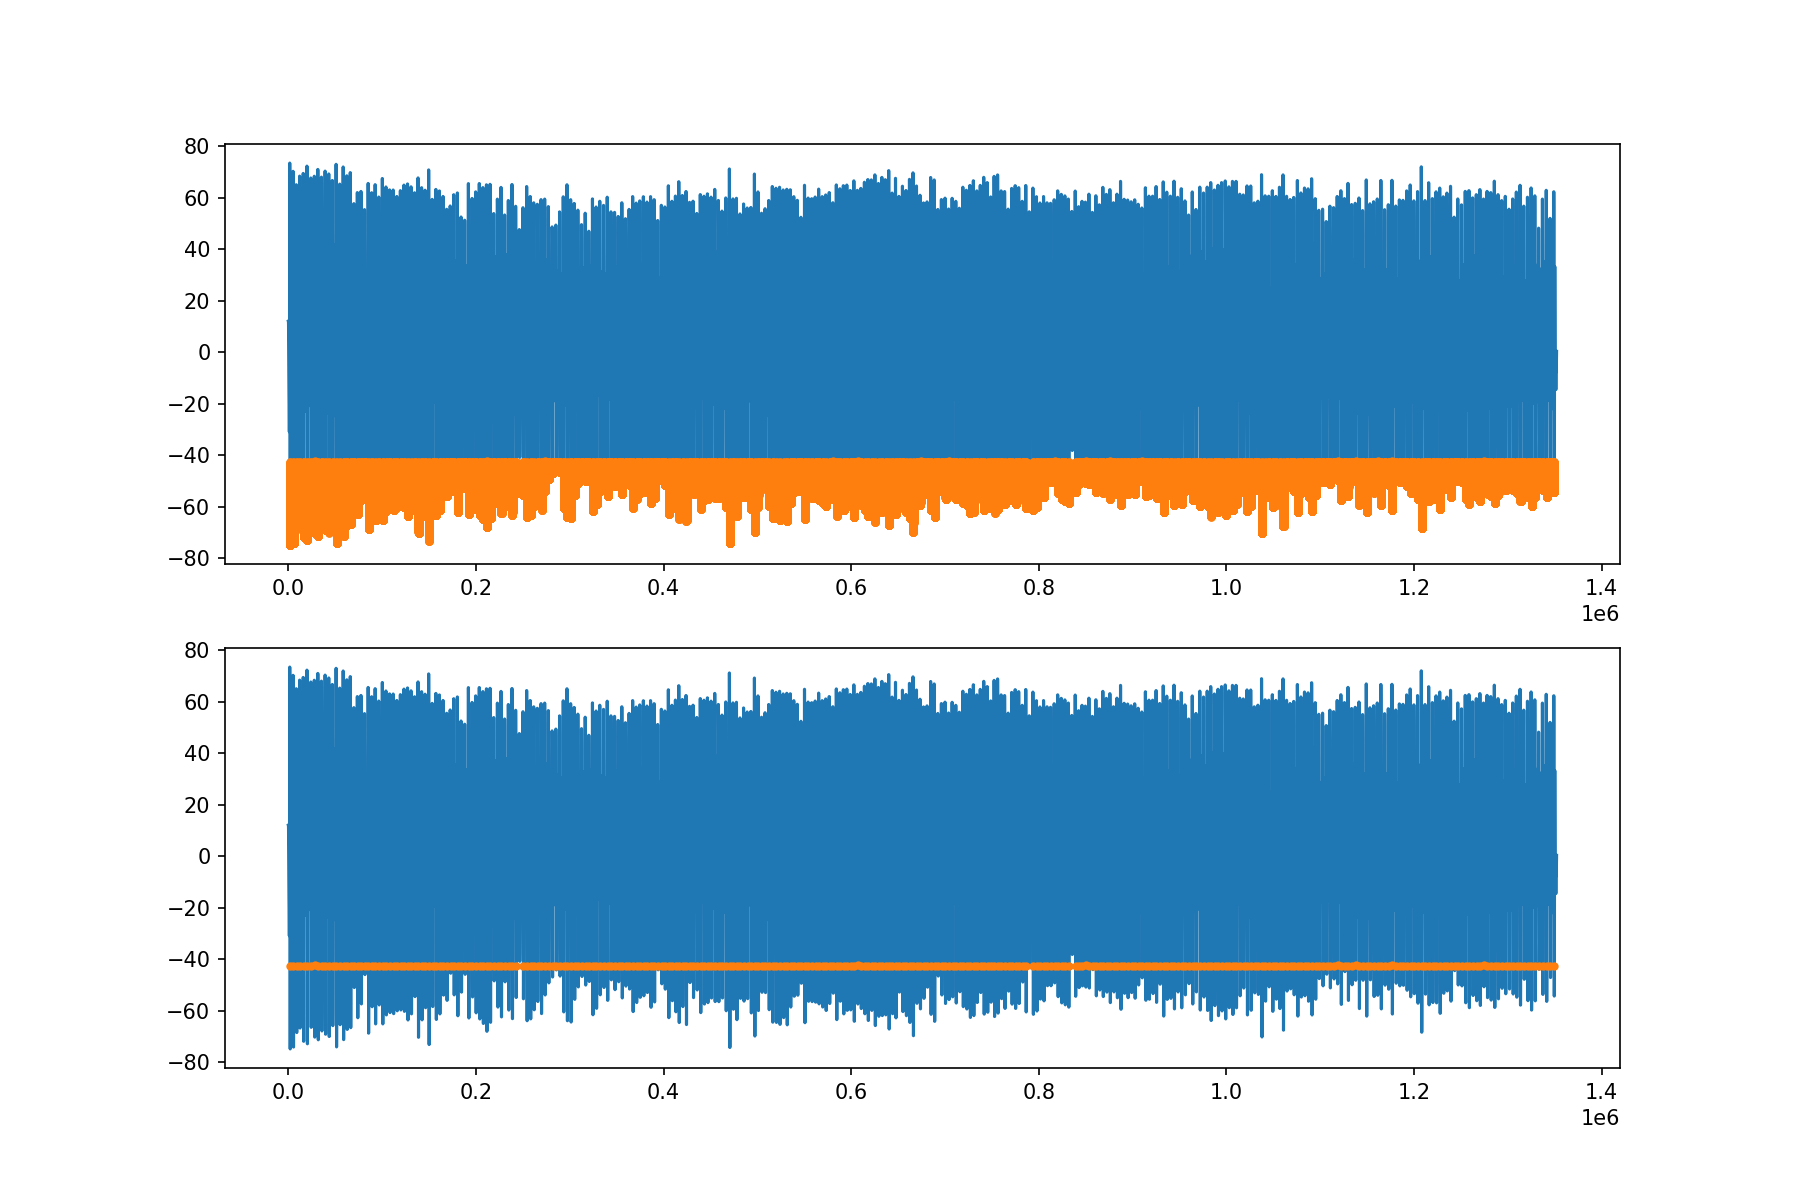

In [76]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(out)
ax[0].plot(inds,out[inds], '.')

new_peaks=reduce_peaks(inds, 2000)
ax[1].plot(out)
ax[1].plot(new_peaks,out[new_peaks], '.')

In [77]:
events_min=new_peaks

In [81]:
zeros=[0]*len(events_min)
marks=[1]*len(events_min)

ones=np.vstack([events_min,zeros,marks]).T


zeros=[0]*len(events_max)
marks=[2]*len(events_max)

twos=np.vstack([events_max,zeros,marks]).T



In [83]:
len(ones)
len(twos)

353

In [91]:
events=np.vstack([ones,twos])
events

array([[   1765,       0,       1],
       [   5302,       0,       1],
       [   8745,       0,       1],
       ...,
       [1340781,       0,       2],
       [1344859,       0,       2],
       [1348839,       0,       2]])

<IPython.core.display.Javascript object>


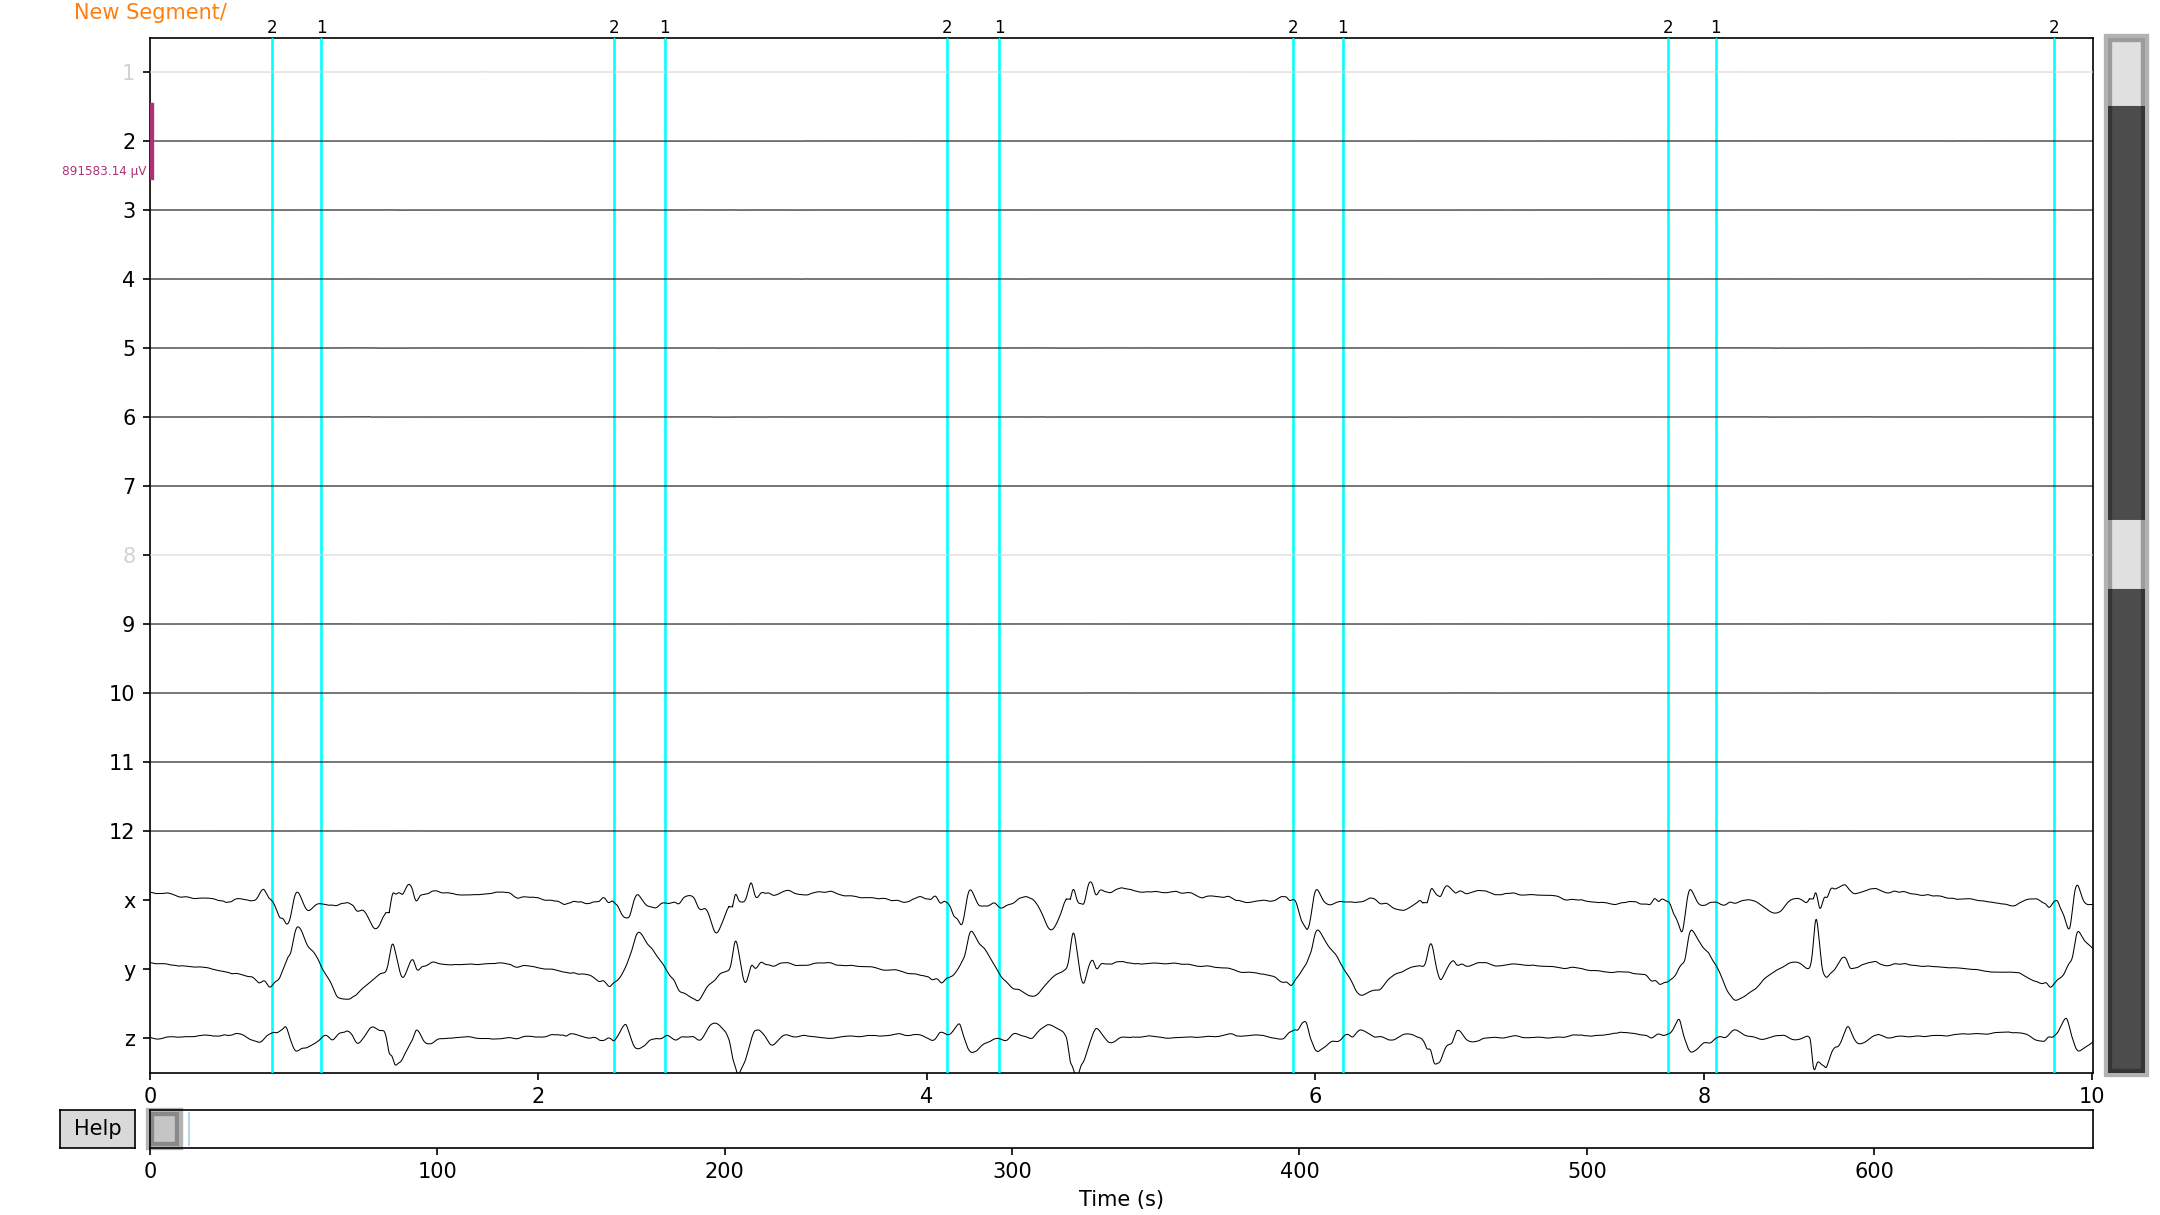

<IPython.core.display.Javascript object>


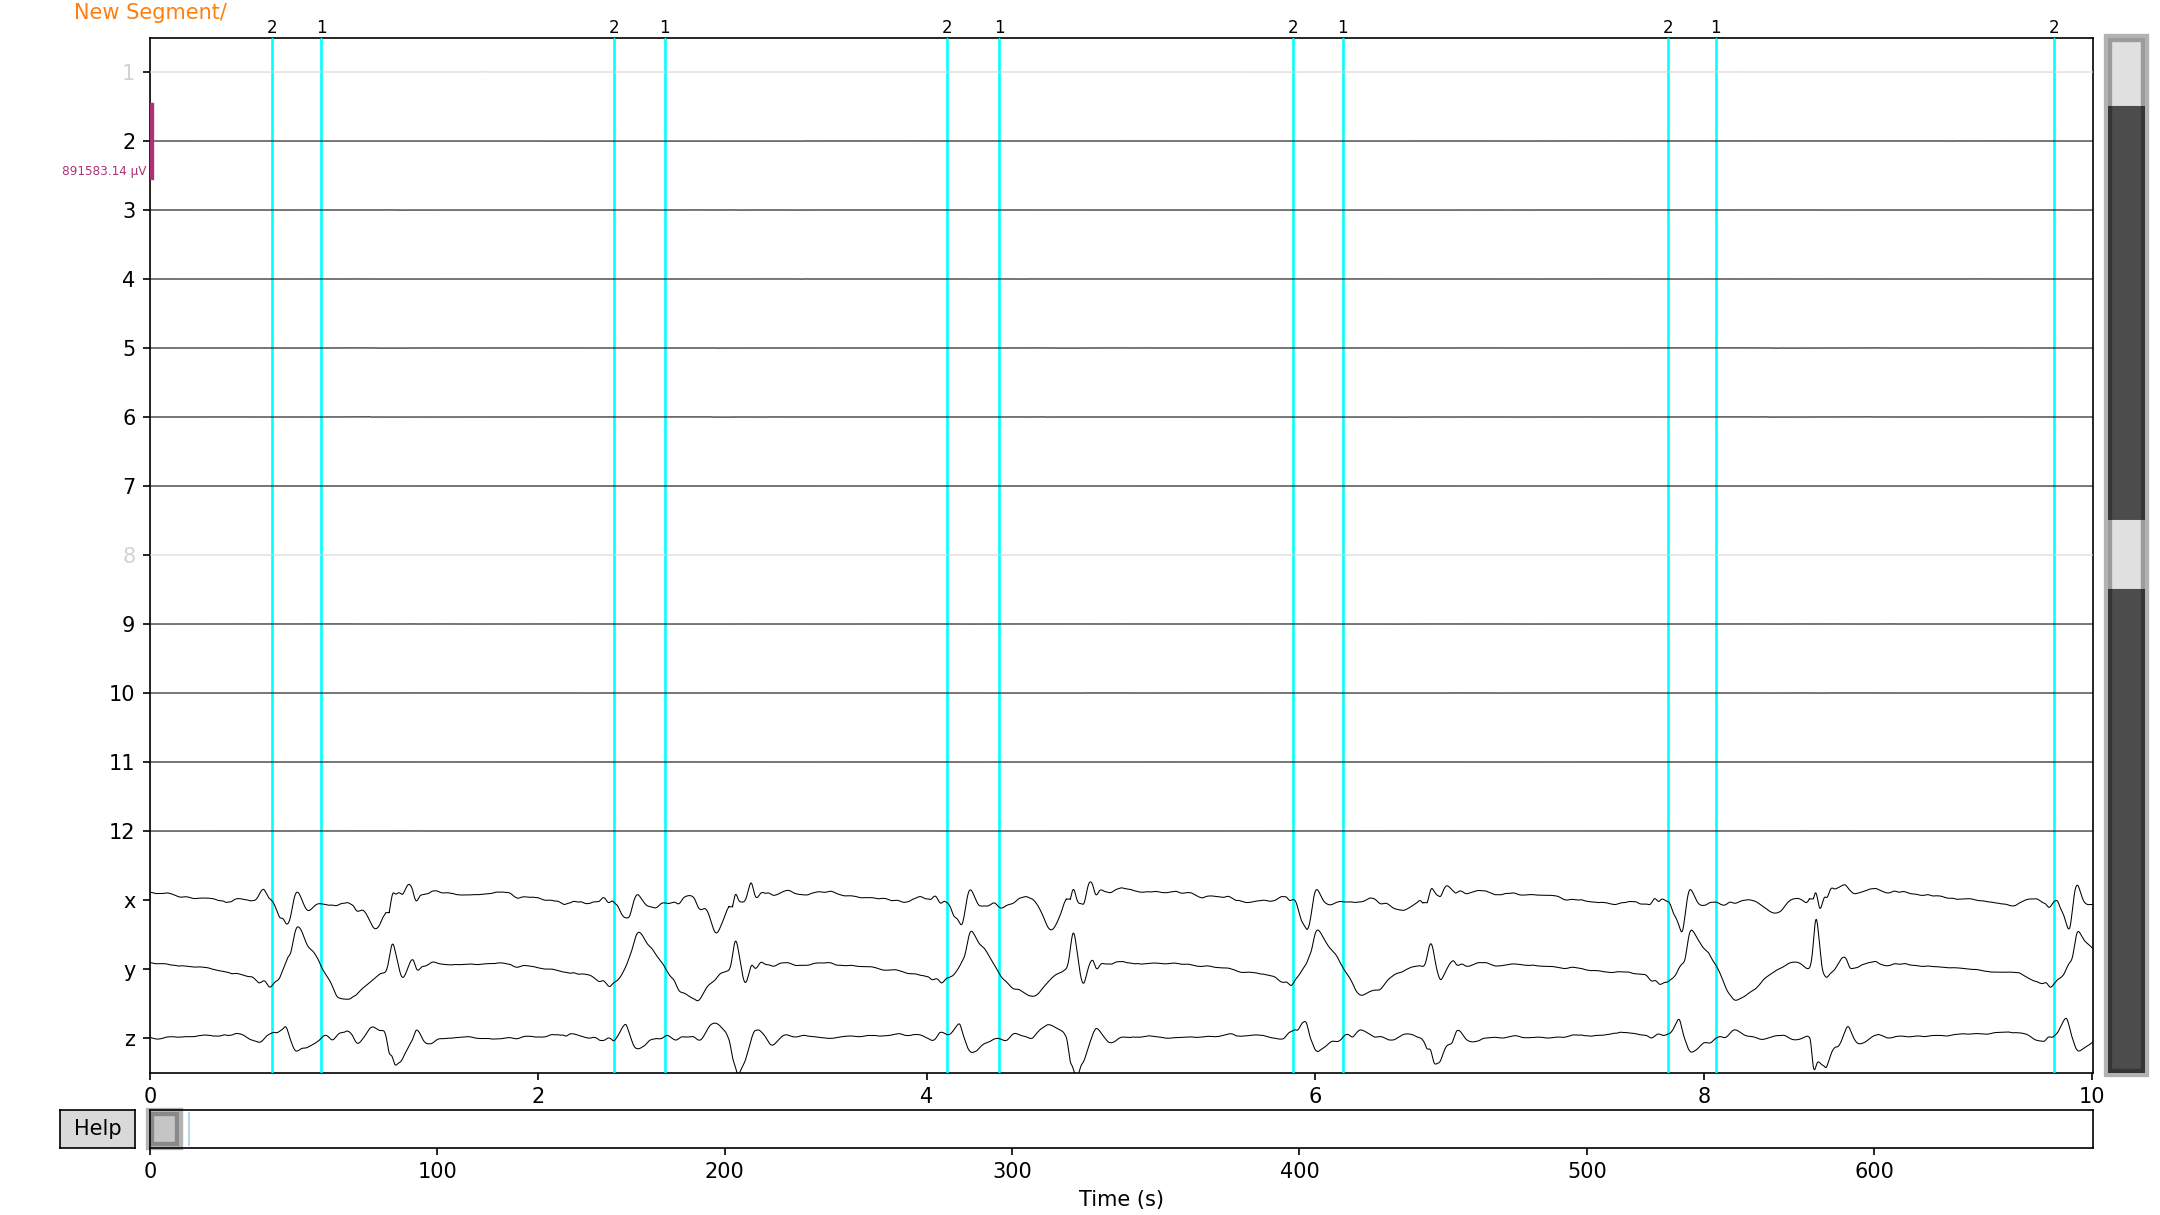

In [94]:
raw_data.plot(events,scalings={'eeg':1e-3})

In [104]:
raw_data_emg=raw_data.copy().drop_channels(['x','y','z'])


SAMPLING_FREQUENCY = raw_data_emg.info['sfreq']
CHANNEL_NUMBER = len(raw_data_emg.ch_names)
BANDPASS_LIMITS = (200, 500)

In [105]:
raw_hil = raw_data_emg.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 125.00 Hz (-6 dB cutoff frequency: 562.50 Hz)
- Filter length: 133 samples (0.067 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter l

In [107]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.2, tmax=0.8, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
703 matching events found
No baseline correction applied
0 projection items activated
Loading data for 703 events and 2001 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_19217/2225999706.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.2, tmax=0.8,


0 bad epochs dropped


In [108]:
epochs

Number of events,703
Events,1: 3502: 353
Time range,-0.200 – 0.800 sec
Baseline,off


In [109]:
def get_features_labels(epochs):
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, SAMPLING_FREQUENCY, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]
        # Mean absolute value
        for channel in raw.get_data():
            x__.append(channel.mean())
        # Matematical expactation
        for channel in raw.get_data():
            x__.append(channel.std())
        # Variance
        for channel in raw.get_data():
            x__.append(channel.var())
        # Waveform length
        for channel in raw.get_data():
            x__.append(np.sum(np.diff(channel, n=1)))
        # Number pf peaks
        for channel in raw.get_data():
            x__.append(len(find_peaks(channel)))
        
        # Append PCA of epoch data
        pca = PCA(6)
        pv = pca.fit_transform(epochs._data[i])
                         
        X.append(x__)
    X = np.array(X).squeeze()
    y = epochs.events[:,-1].flatten()
    return X, y


In [118]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (703, 60)
Y:  (703,)


In [119]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.8236130867709816

In [122]:
events_min

[1765,
 5302,
 8745,
 12282,
 16121,
 20117,
 24168,
 27945,
 31708,
 35569,
 39486,
 43374,
 47186,
 51185,
 55024,
 58735,
 62562,
 66305,
 70186,
 73856,
 77721,
 81548,
 85364,
 89125,
 92831,
 96668,
 100502,
 104333,
 108201,
 112055,
 115909,
 119745,
 123556,
 127345,
 131087,
 134860,
 138555,
 142369,
 146077,
 149879,
 153672,
 157579,
 161357,
 165237,
 169068,
 172928,
 176634,
 180519,
 184443,
 188352,
 192249,
 196173,
 200028,
 203878,
 207713,
 211485,
 215342,
 219295,
 223200,
 227030,
 230920,
 234839,
 238716,
 242691,
 250473,
 254366,
 258169,
 261920,
 265791,
 269729,
 273605,
 277552,
 281544,
 285597,
 289549,
 293383,
 297316,
 301256,
 305103,
 308986,
 312921,
 316842,
 320678,
 324519,
 328417,
 332338,
 336356,
 340285,
 344228,
 348114,
 352013,
 355845,
 359709,
 363586,
 367373,
 371166,
 374934,
 378798,
 382630,
 386451,
 390267,
 394153,
 397993,
 401686,
 405421,
 409235,
 412959,
 416531,
 420349,
 424245,
 428016,
 431766,
 435693,
 439466,
 44

In [126]:
zeros=[0]*len(events_min)
marks=[3]*len(events_min)

threes=np.vstack([np.array(events_min)+500,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T



In [127]:

events=np.vstack([ones,twos, threes])


<IPython.core.display.Javascript object>


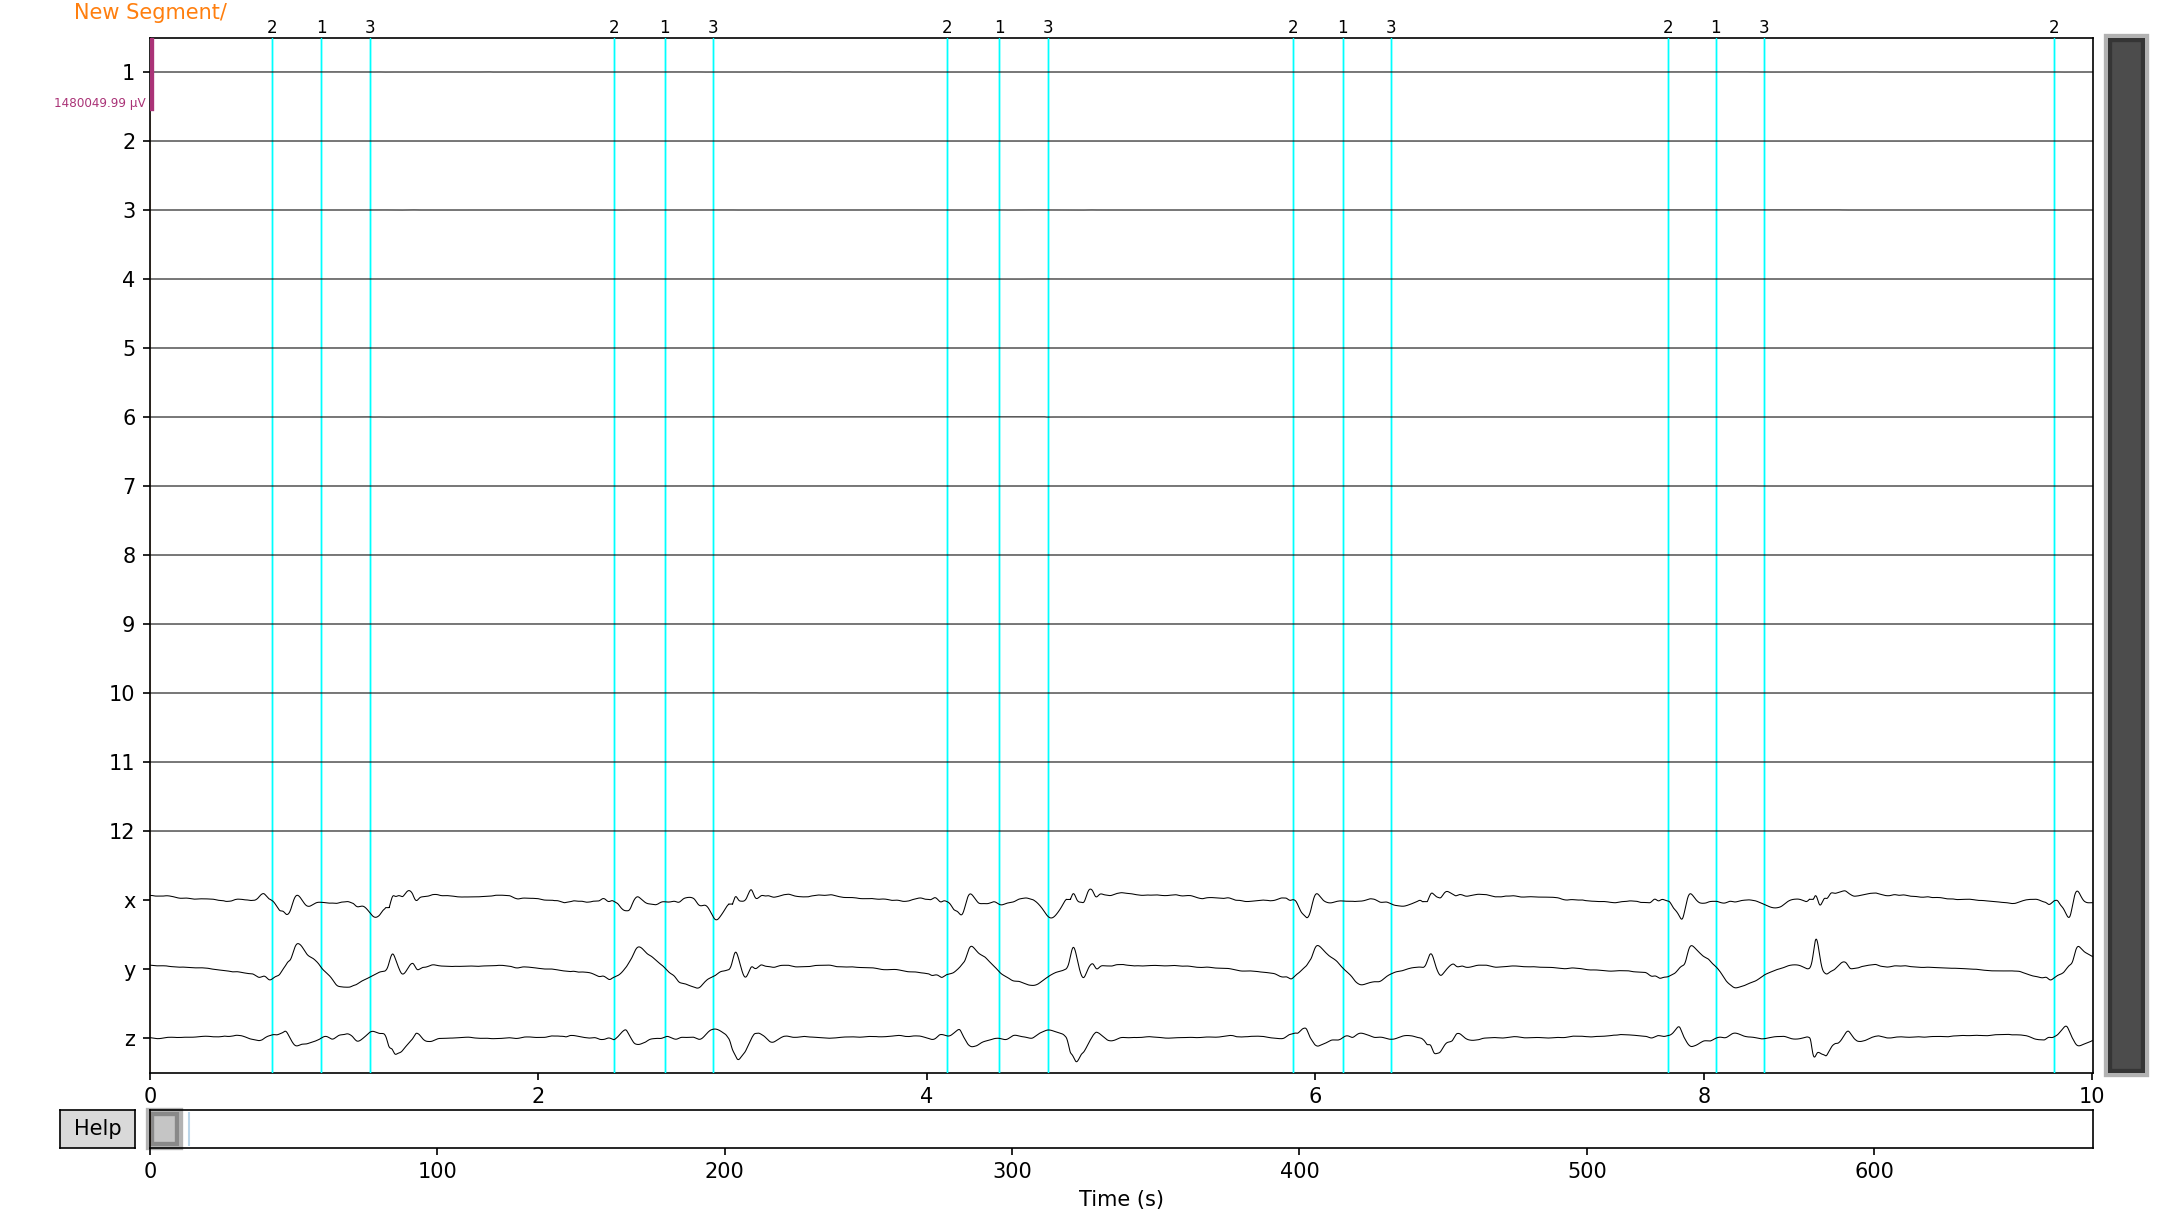

<IPython.core.display.Javascript object>


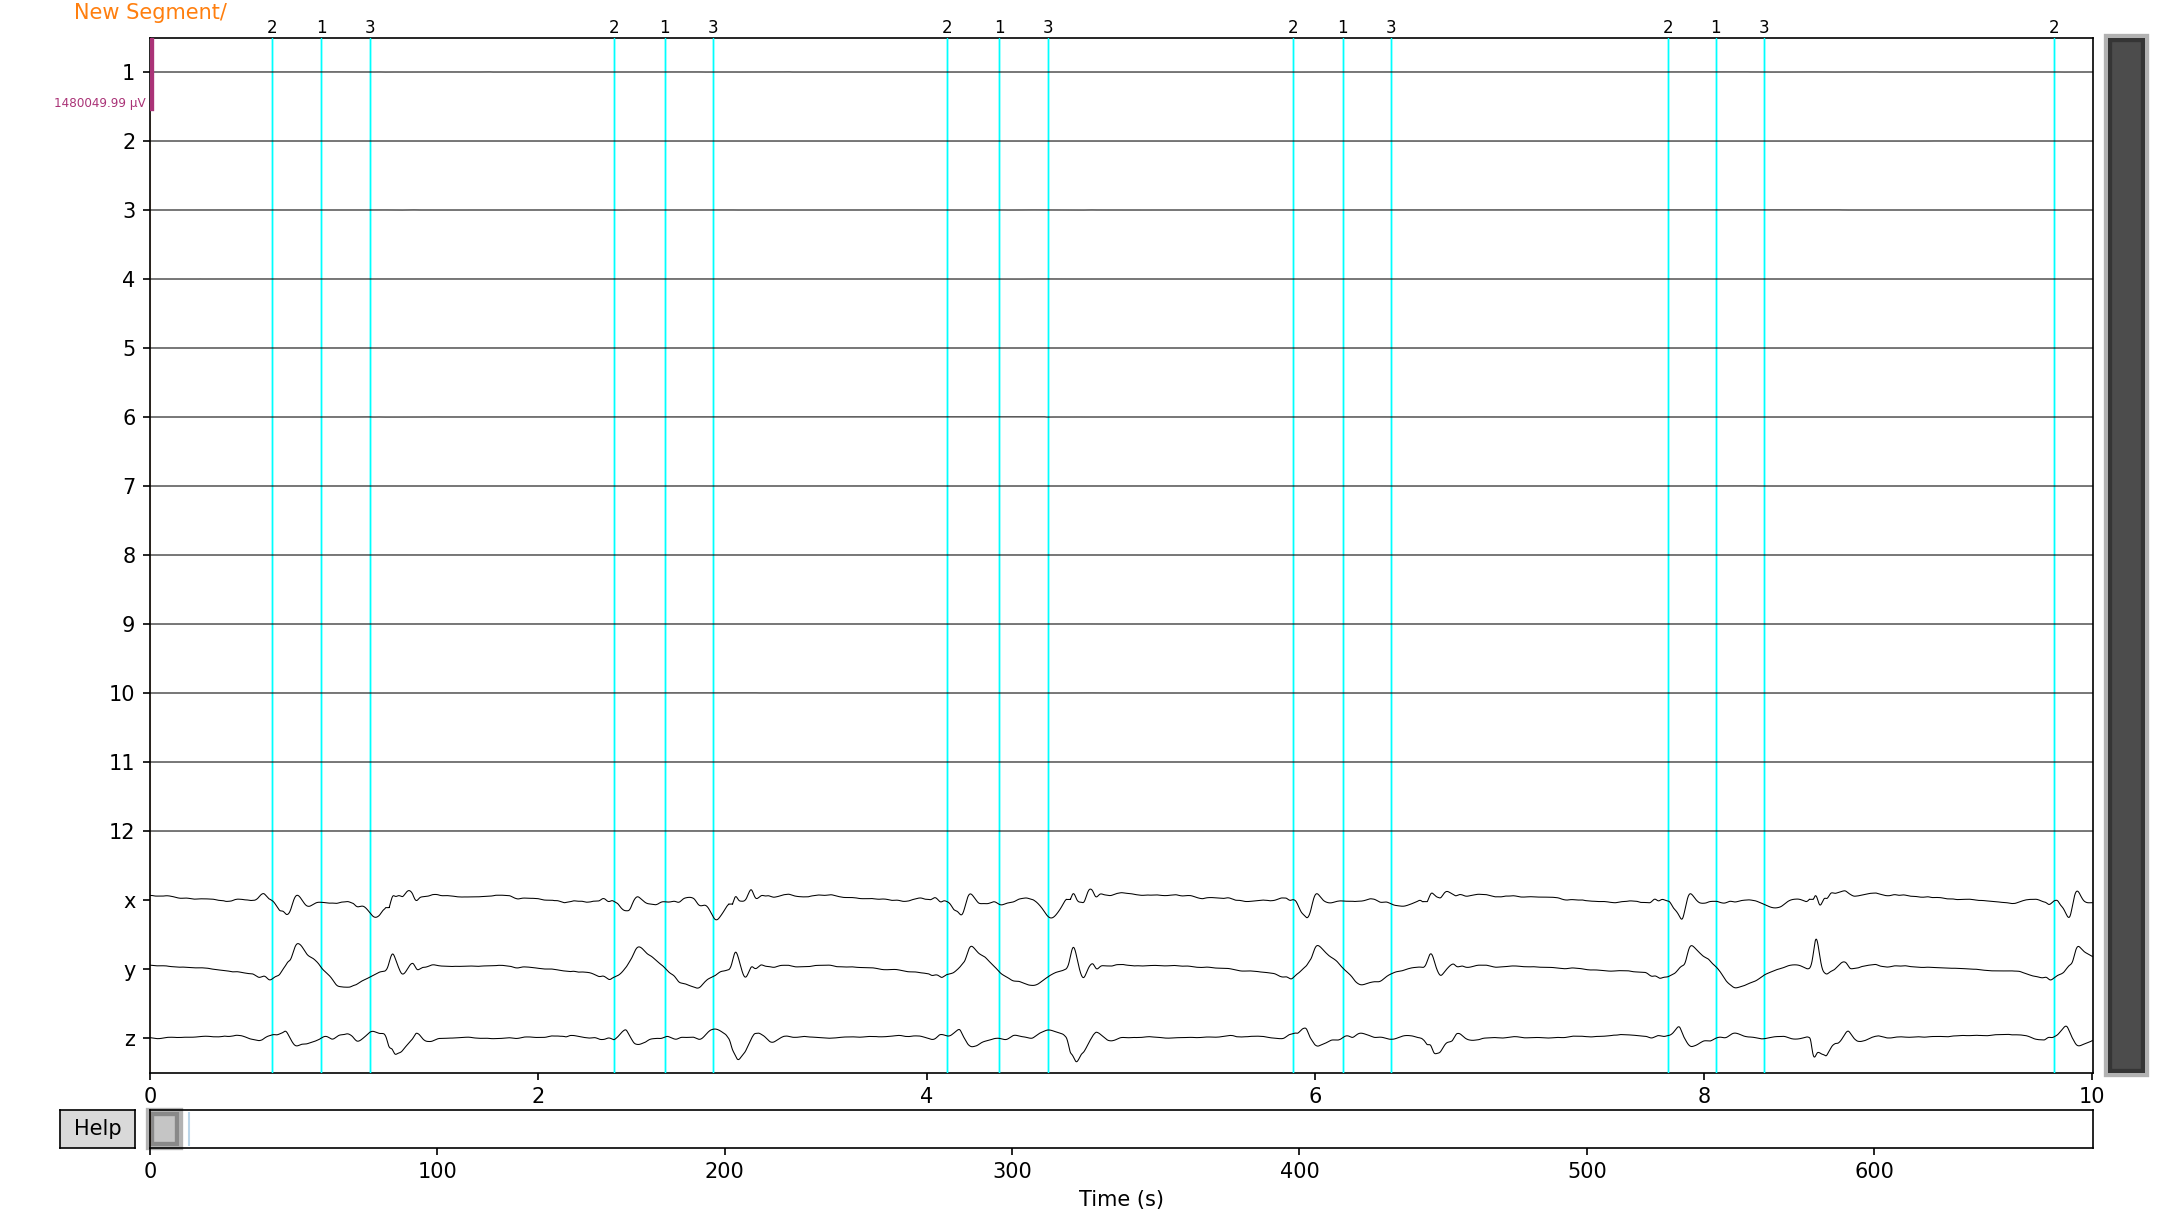

In [130]:
raw_data.plot(events,scalings={'eeg':1e-1})

In [134]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1053 events and 1201 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_19217/4011406920.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1,


0 bad epochs dropped


In [135]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (1053, 60)
Y:  (1053,)


In [136]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.7075023741690408

In [137]:
zeros=[0]*len(events_min)
marks=[4]*len(events_min)

fores=np.vstack([np.array(events_min)+1000,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T



In [138]:

events=np.vstack([ones,twos, threes, fores])


<IPython.core.display.Javascript object>


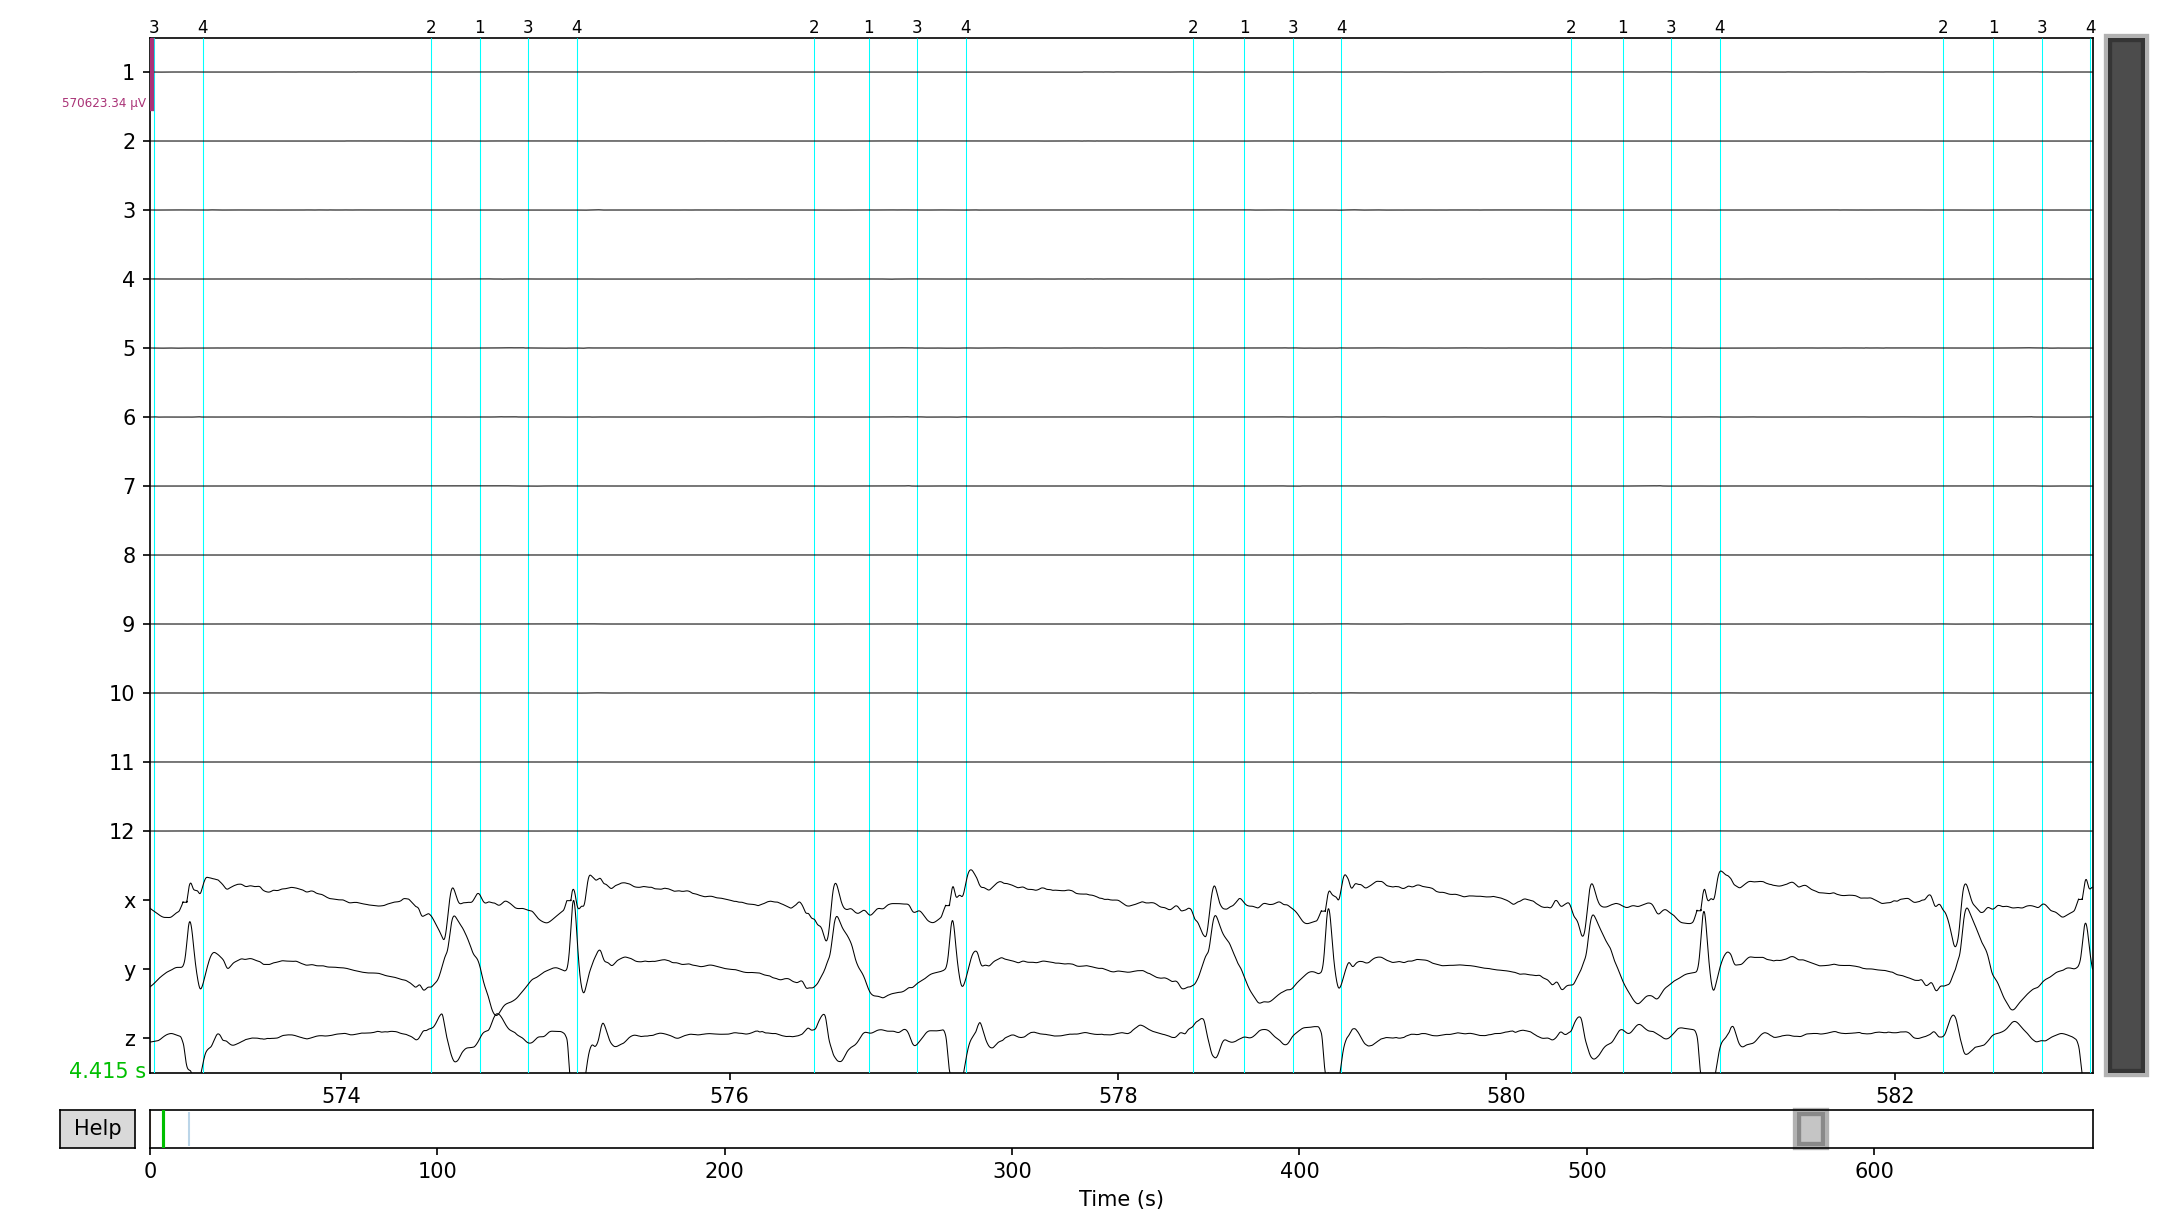

<IPython.core.display.Javascript object>


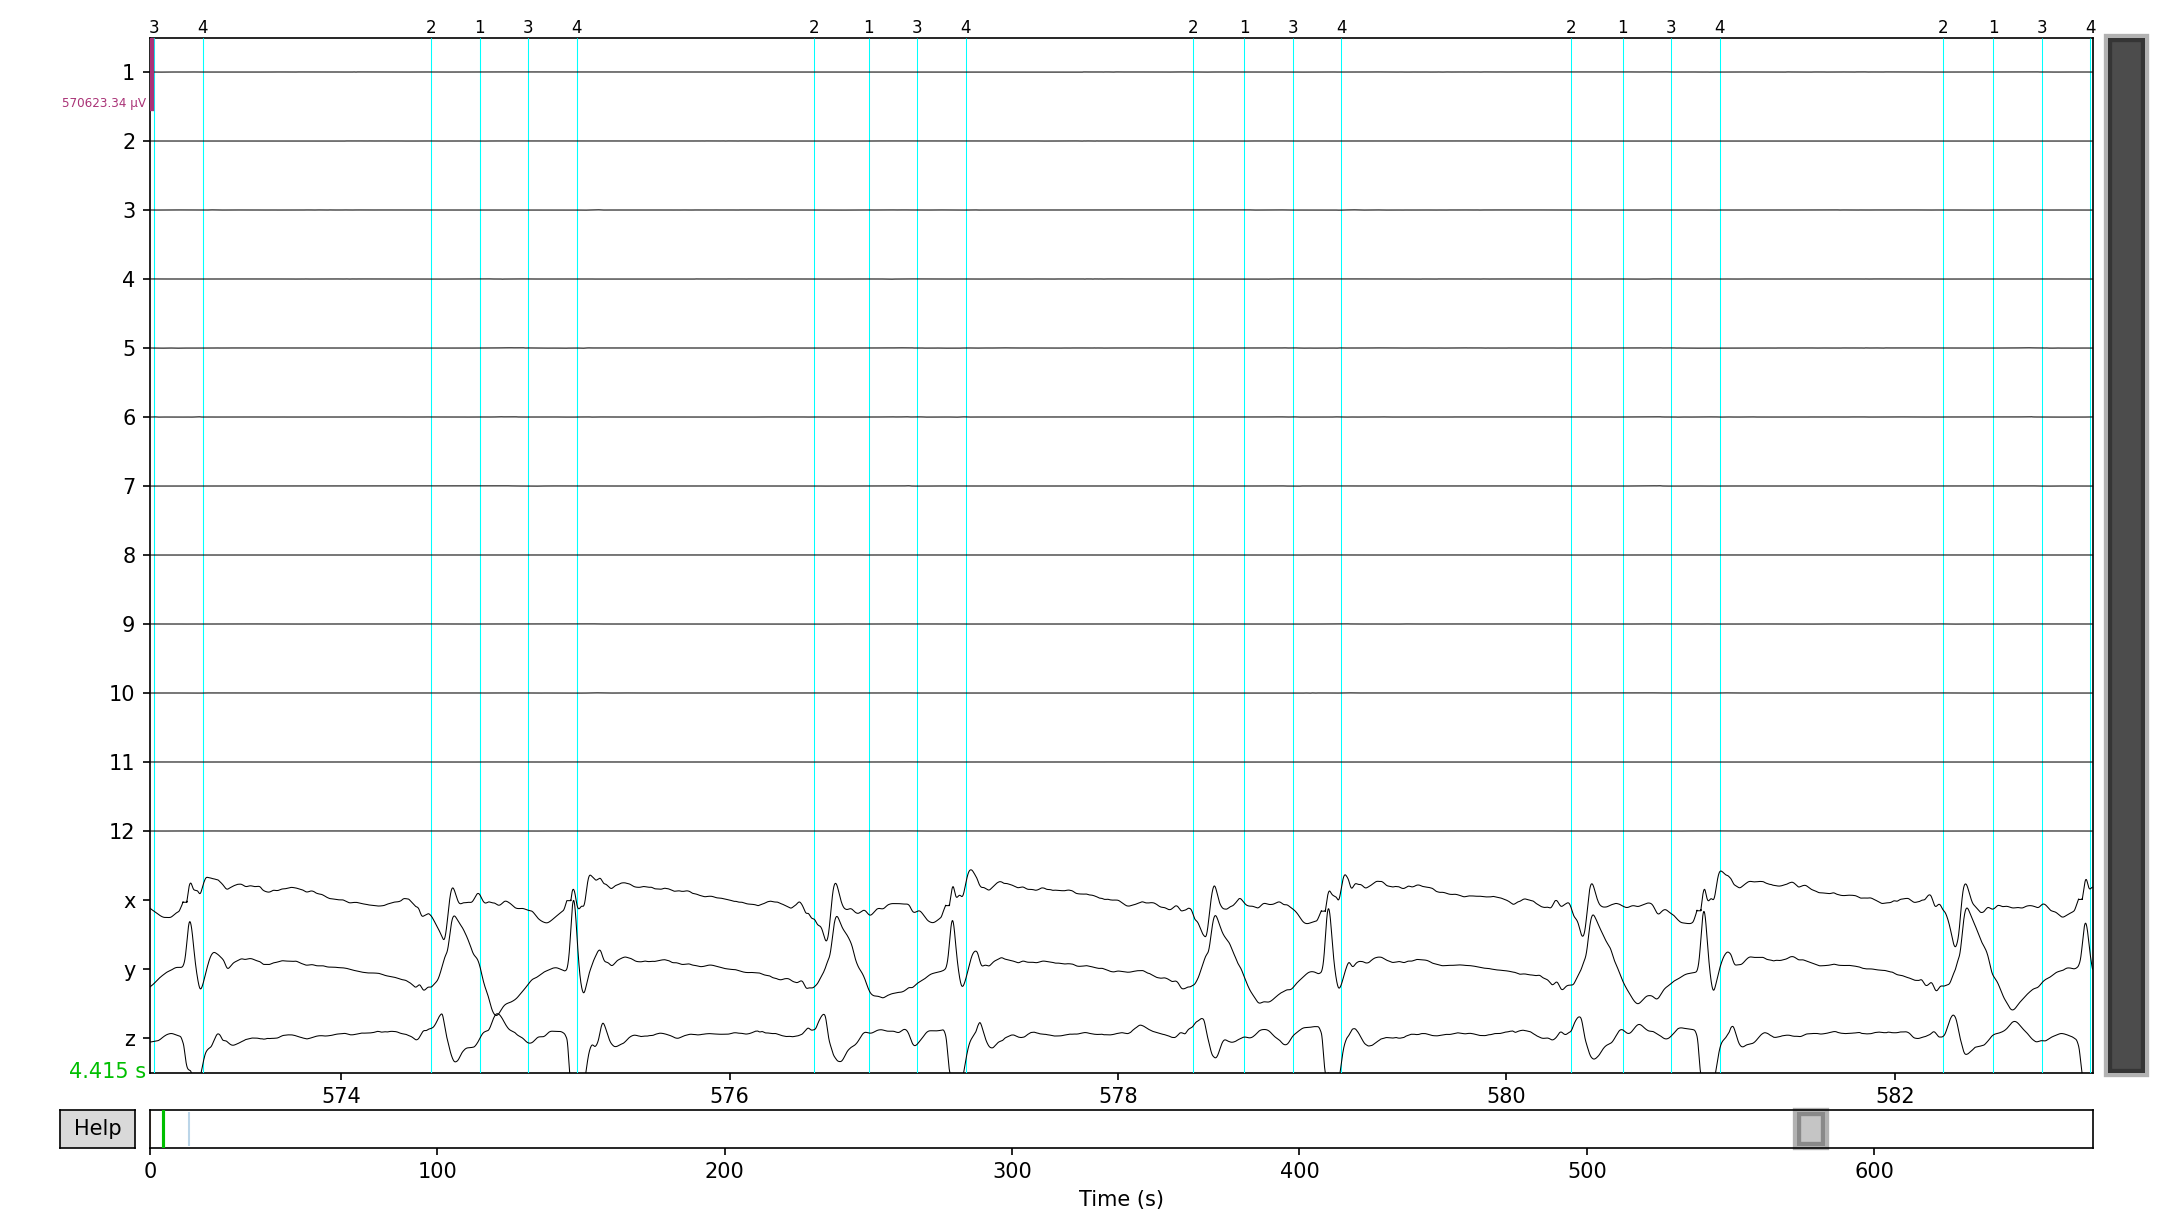

In [139]:
raw_data.plot(events,scalings={'eeg':1e-1})

In [140]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1403 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1403 events and 1201 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_19217/4011406920.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1,


0 bad epochs dropped


In [141]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (1403, 60)
Y:  (1403,)


In [142]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.6329294369208838